## Credit Risk Analysis - 



<b>DATA AVAILABLE</b>: Bankloans.csv
The data contains the credit details about credit borrowers:
Data Description:<br>

age - Age of Customer<br>
ed - Eductation level of customer <br>
employ: Tenure with current employer (in years) <br>
address: Number of years in same address <br>
income: Customer Income <br>
debtinc: Debt to income ratio <br>
creddebt: Credit to Debt ratio <br>
othdebt: Other debts <br>
default: Customer defaulted in the past (1= defaulted, 0=Never defaulted) <br>

In [268]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.formula.api as sm
import scipy.stats as stats
import pandas_profiling  

%matplotlib inline
plt.rcParams['figure.figsize'] = 10, 7.5
plt.rcParams['axes.grid'] = True
plt.gray()

from matplotlib.backends.backend_pdf import PdfPages

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices

<Figure size 720x540 with 0 Axes>

<b> Data Pre-Processing - </b>
- Missing Values Treatment - Numerical (Mean/Median imputation) and Categorical (Separate Missing Category or Merging)
- Univariate Analysis - Outlier and Frequency Analysis

In [269]:
bankloans=pd.read_csv('../input/bankloans.csv')

In [270]:
len(bankloans)

850

In [271]:
## Generic functions for data explorations
def var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  x.std(), x.var(), x.min(), x.dropna().quantile(0.01), x.dropna().quantile(0.05),x.dropna().quantile(0.10),x.dropna().quantile(0.25),x.dropna().quantile(0.50),x.dropna().quantile(0.75), x.dropna().quantile(0.90),x.dropna().quantile(0.95), x.dropna().quantile(0.99),x.max()], 
                  index=['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1' , 'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])


def cat_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.value_counts()], 
                  index=['N', 'NMISS', 'ColumnsNames'])

def create_dummies( df, colname ):
    col_dummies = pd.get_dummies(df[colname], prefix=colname)
    col_dummies.drop(col_dummies.columns[0], axis=1, inplace=True)
    df = pd.concat([df, col_dummies], axis=1)
    df.drop( colname, axis = 1, inplace = True )
    return df

#Handling outliers
def outlier_capping(x):
    x = x.clip_upper(x.quantile(0.99))
    x = x.clip_lower(x.quantile(0.01))
    return x

def Missing_imputation(x):
    x = x.fillna(x.mean())
    return x


In [272]:
bankloans.apply(lambda x: var_summary(x)).T


,N,NMISS,SUM,MEAN,MEDIAN,STD,VAR,MIN,P1,P5,P10,P25,P50,P75,P90,P95,P99,MAX
age,850.0,0.0,29775.000000,35.029412,34.000000,8.041432,64.664623,20.000000,21.000000,23.000000,25.000000,29.000000,34.000000,41.000000,47.000000,49.000000,53.000000,56.00000
ed,850.0,0.0,1454.000000,1.710588,1.000000,0.927784,0.860783,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,3.000000,4.000000,4.000000,5.00000
employ,850.0,0.0,7281.000000,8.565882,7.000000,6.777884,45.939706,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000,13.000000,18.000000,21.550000,29.000000,33.00000
address,850.0,0.0,7116.000000,8.371765,7.000000,6.895016,47.541251,0.000000,0.000000,0.000000,1.000000,3.000000,7.000000,12.000000,19.000000,22.550000,26.510000,34.00000
income,850.0,0.0,39674.000000,46.675294,35.000000,38.543054,1485.566998,13.000000,14.490000,17.000000,19.000000,24.000000,35.000000,55.750000,84.000000,115.550000,220.510000,446.00000
debtinc,850.0,0.0,8645.900000,10.171647,8.700000,6.719441,45.150891,0.100000,0.900000,1.900000,2.900000,5.100000,8.700000,13.800000,19.200000,23.510000,31.565000,41.30000
creddebt,850.0,0.0,1340.284021,1.576805,0.885091,2.125840,4.519196,0.011696,0.030349,0.108927,0.178306,0.382176,0.885091,1.898440,3.703304,5.348674,10.285997,20.56131
othdebt,850.0,0.0,2616.970979,3.078789,2.003243,3.398803,11.551864,0.045584,0.162394,0.359900,0.552050,1.045942,2.003243,3.903001,7.111941,9.481105,16.931503,35.19750
default,700.0,150.0,183.000000,0.261429,0.000000,0.439727,0.193360,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.00000


Seeing the above data there are <b>few outliers</b> in the dataset in moving from 99 to 100 percentile.</br>
In practise its better to cap the outliers

However there are <b>missing values for the dependent variables</b>, However the missing values means that these are the <b>new customers</b> for whom we need to evaluate if we need to provide loans or not. Hence we will be building the model with <b>existing customers</b> only.


In [273]:
bankloans_existing = bankloans[bankloans.default.isnull()==0]
bankloans_new = bankloans[bankloans.default.isnull()==1]

In [274]:
bankloans_existing=bankloans_existing.apply(lambda x: outlier_capping(x))
bankloans_existing=bankloans_existing.apply(lambda x: Missing_imputation(x))

In [275]:
numeric_var_names=[key for key in dict(bankloans.dtypes) if dict(bankloans.dtypes)[key] in ['float64', 'int64', 'float32', 'int32']]
cat_var_names=[key for key in dict(bankloans.dtypes) if dict(bankloans.dtypes)[key] in ['object']]

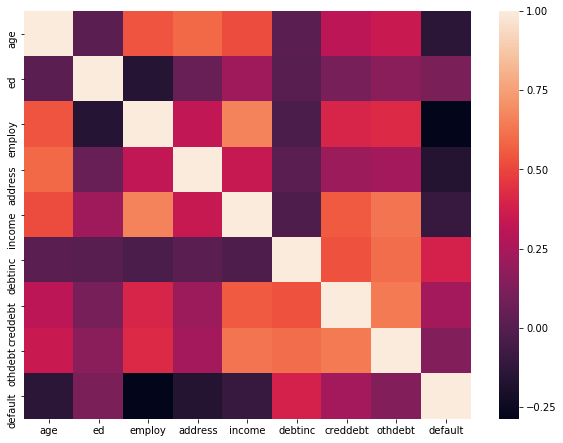

In [276]:
sns.heatmap(bankloans_existing.corr())

The above correlation depicts that there is very strong correlation between default ~ employ,address, income
Also debtinc shows very strong relationship with income, and is expected as the same is derived variable from income and debt.


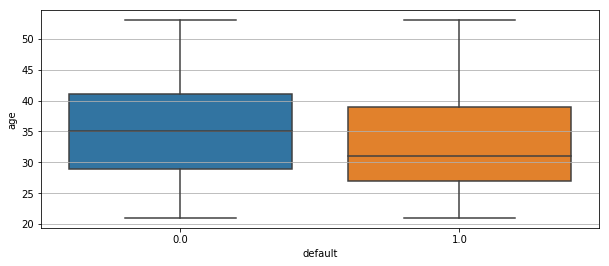

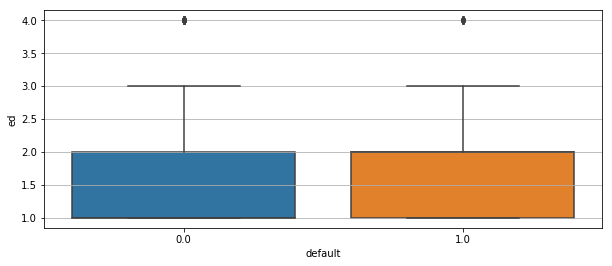

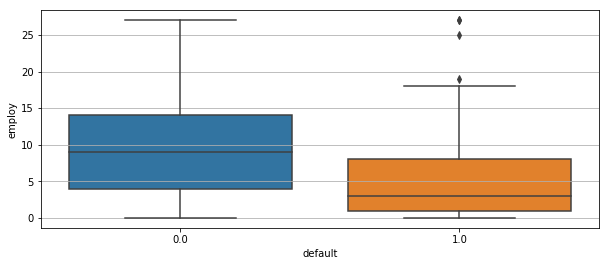

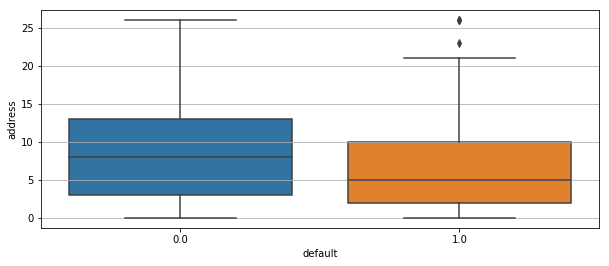

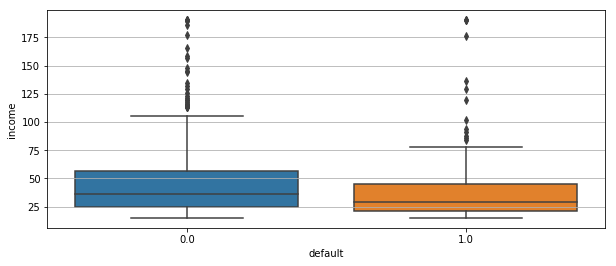

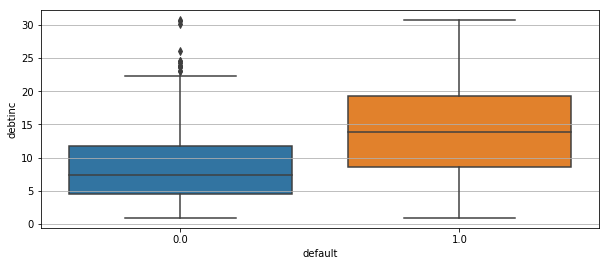

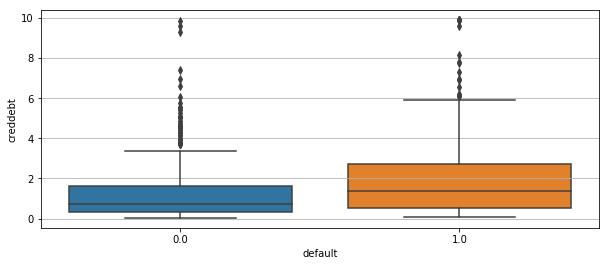

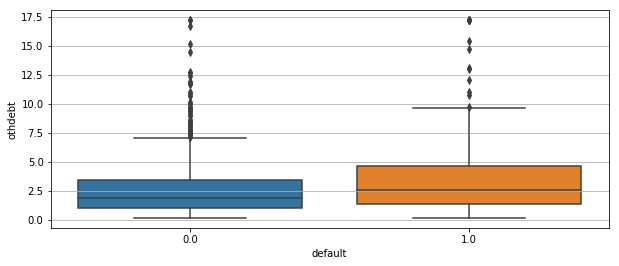

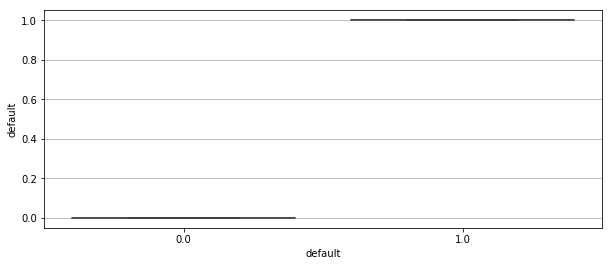

In [277]:
bp = PdfPages('BoxPlots with default Split.pdf')

for num_variable in numeric_var_names:
    fig,axes = plt.subplots(figsize=(10,4))
    sns.boxplot(x='default', y=num_variable, data = bankloans_existing)
    bp.savefig(fig)
bp.close()

Lets evalulate the above plots with the different variables and see if they make sense with fetching some information.

Age - It depicts that people with lower age group tends to default more than with higher age group<br>
creddebt  - People with higher creddebt tends to default more often which is expected in normal circumstances.<br>
address - This depicts that people who are living at the same location for less duration tends to default more.<br>
debtinc - People with higher debtinc ratio tends to default more often which is expected in normal circumstances.<br>
emply - This depicts that people who are employed more recently tends to default more in comparison to the senior people.<br>

Well these interpretations confirms that some of the basic assumptions are being followed with the given dataset.

### Data Exploratory Analysis
- Bivariate Analysis - TTest<br>

Below ttest is performed to check the relationship between the independent samples in respect to the dependent variables. This helps us to identify if the variable is biased towards any given segment of the dependent variables. 

Our H0 Hypothesis is that the independent samples of num_variable is not biased / related to the dependent variable i.e. default. However if Pvalue is higher then the variables are independent and are not significant for the model. We may exclue some of them based on pvalue and some other statistics that we will calculate below


In [278]:
tstats_df = pd.DataFrame()
for num_variable in bankloans_existing.columns.difference(['default']):
    tstats=stats.ttest_ind(bankloans_existing[bankloans_existing.default==1][num_variable],bankloans_existing[bankloans_existing.default==0][num_variable])
    temp = pd.DataFrame([num_variable, tstats[0], tstats[1]]).T
    temp.columns = ['Variable Name', 'T-Statistic', 'P-Value']
    tstats_df = pd.concat([tstats_df, temp], axis=0, ignore_index=True)
print(tstats_df)

  Variable Name T-Statistic      P-Value
0       address    -4.43055  1.09104e-05
1           age    -3.69893  0.000233527
2      creddebt     6.47909   1.7428e-10
3       debtinc     11.1409  1.20241e-26
4            ed     3.15351   0.00168236
5        employ    -7.92136  9.27995e-15
6        income    -2.64329   0.00839468
7       othdebt      3.7073  0.000226095


This shows that age,ed,income and otherdebt are comparatively insignifincat but can not be ignored on the basis on Ttest. 

### Visualization of variable importance

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/opt/conda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
/opt/conda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


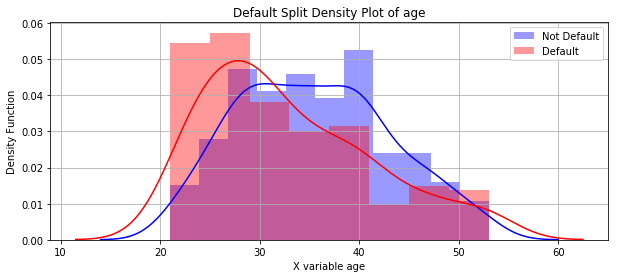

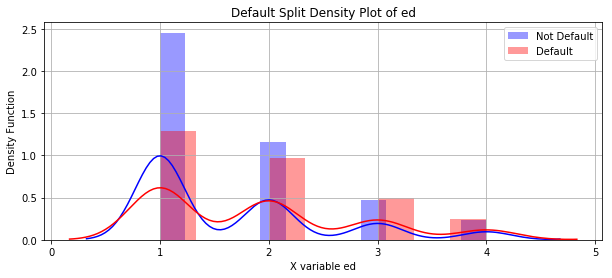

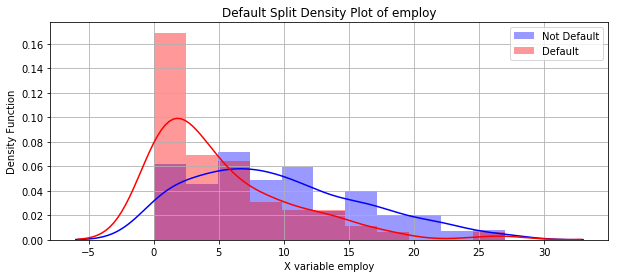

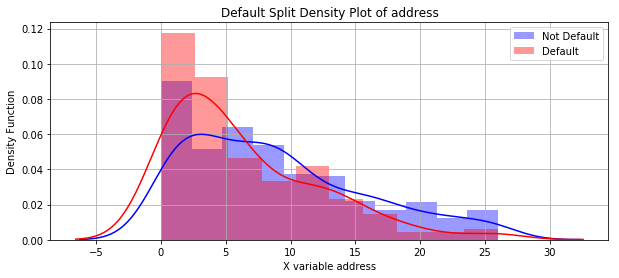

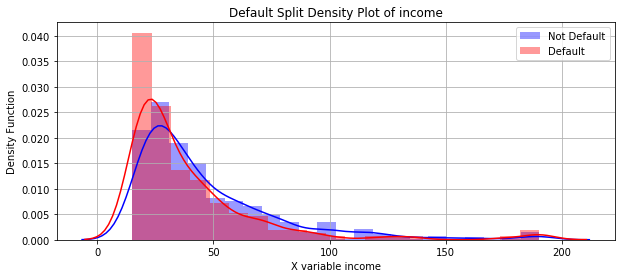

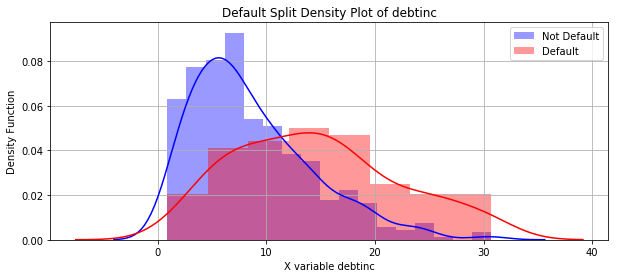

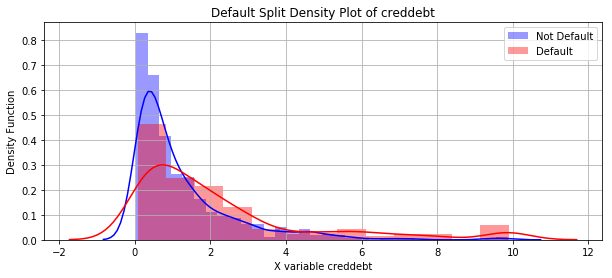

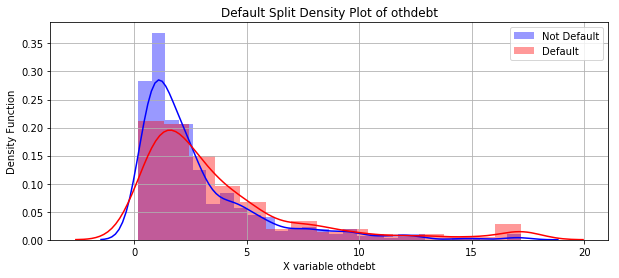

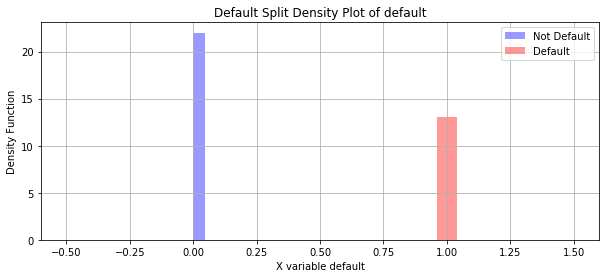

In [279]:
for num_variable in numeric_var_names:
    fig,axes = plt.subplots(figsize=(10,4))
    sns.distplot(bankloans_existing[bankloans_existing['default']==0][num_variable], label='Not Default', color='b', hist=True, norm_hist=False)
    sns.distplot(bankloans_existing[bankloans_existing['default']==1][num_variable], label='Default', color='r', hist=True, norm_hist=False)
    plt.xlabel(str("X variable ") + str(num_variable) )
    plt.ylabel('Density Function')
    plt.title(str('Default Split Density Plot of ')+str(num_variable))
    plt.legend()

### Logit Plot

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys


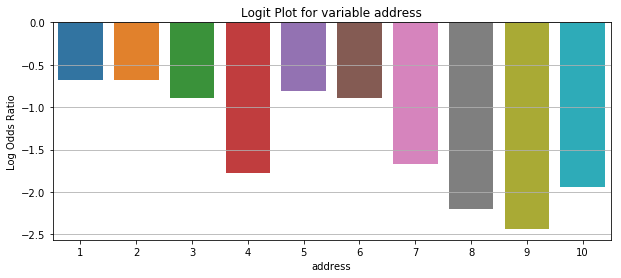

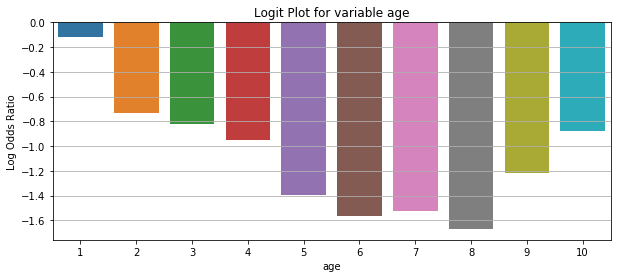

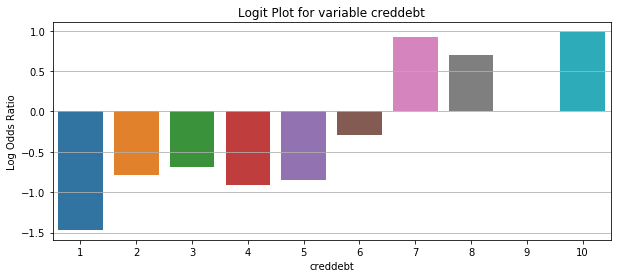

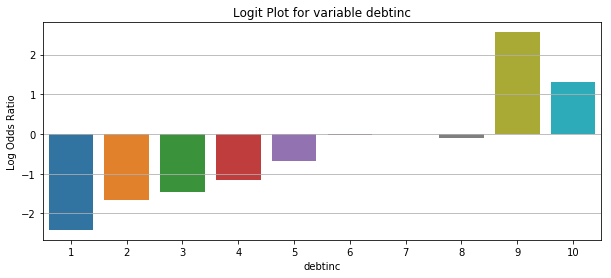

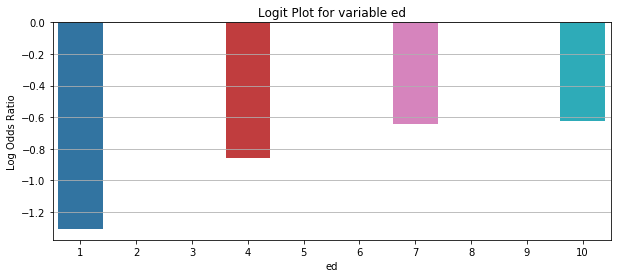

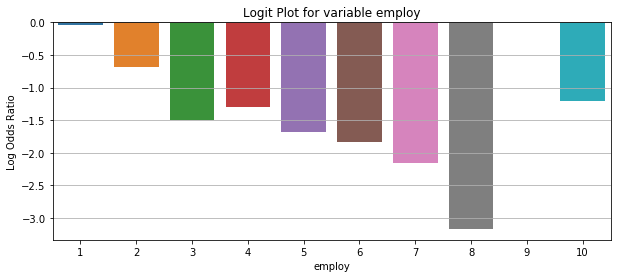

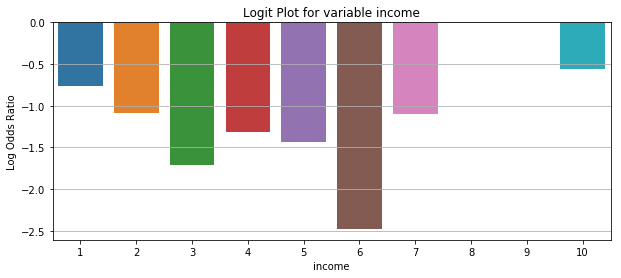

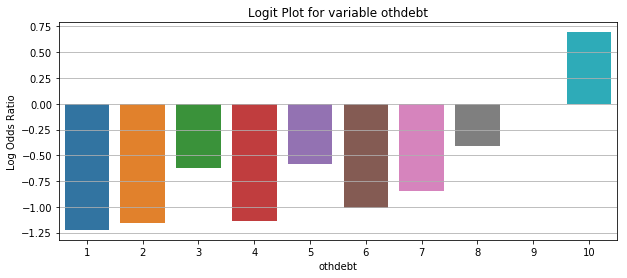

In [280]:
bp = PdfPages('Transformation Plots.pdf')

for num_variable in bankloans_existing.columns.difference(['default']):
    binned = pd.cut(bankloans_existing[num_variable], bins=10, labels=list(range(1,11)))
    binned = binned.dropna()
    ser = bankloans_existing.groupby(binned)['default'].sum() / (bankloans_existing.groupby(binned)['default'].count()-bankloans_existing.groupby(binned)['default'].sum())
    ser = np.log(ser)
    fig,axes = plt.subplots(figsize=(10,4))
    sns.barplot(x=ser.index,y=ser)
    plt.ylabel('Log Odds Ratio')
    plt.title(str('Logit Plot for variable ') + str(num_variable))
    bp.savefig(fig)

bp.close()

In [281]:
print('These variables do not follow trend - creddebt, othdebt, debtinc, employ, income ')
bankloans_existing.columns

These variables do not follow trend - creddebt, othdebt, debtinc, employ, income 


Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

In [282]:
bankloans_existing[['creddebt', 'othdebt', 'debtinc', 'employ','income' ]].describe(percentiles=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]).T

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,max
creddebt,700.0,1.498843,1.788451,0.030209,0.170020,0.301390,0.440418,0.593059,0.854869,1.183471,1.615023,2.288026,3.621504,9.891428
othdebt,700.0,3.027290,3.115401,0.160936,0.562232,0.900747,1.165766,1.546101,1.987567,2.511054,3.258777,4.577926,7.036180,17.184744
debtinc,700.0,10.222153,6.682160,0.900000,2.900000,4.500000,5.800000,7.000000,8.600000,10.500000,12.900000,15.440000,19.610000,30.701000
employ,700.0,8.358671,6.566008,0.000000,1.000000,2.000000,4.000000,5.600000,7.000000,9.000000,11.000000,14.000000,18.000000,27.010000
income,700.0,44.848714,31.942133,15.000000,19.000000,22.000000,26.000000,29.000000,34.000000,40.400000,49.000000,61.000000,82.000000,190.300000


In [283]:
features = "+".join(bankloans_existing.columns.difference(['default']))
a,b = dmatrices(formula_like='default ~ '+ features, data = bankloans_existing, return_type='dataframe')

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(b.values, i) for i in range(b.shape[1])]
vif["features"] = b.columns

print(vif)

   VIF Factor   features
0   36.910987  Intercept
1    1.561802    address
2    2.037593        age
3    2.628899   creddebt
4    3.910509    debtinc
5    1.287345         ed
6    2.401544     employ
7    5.121585     income
8    4.562072    othdebt


### It seems that age,ed  are not significant for medelling as their VIF is also low and Pvalue was high

In [284]:
train_features = bankloans_existing.columns.difference(['default'])
train_X, test_X = train_test_split(bankloans_existing, test_size=0.3, random_state=42)
train_X.columns

Index(['age', 'ed', 'employ', 'address', 'income', 'debtinc', 'creddebt',
       'othdebt', 'default'],
      dtype='object')

## Implementing the logistic regression via Statistical model

In [285]:
logreg = sm.logit(formula='default ~ ' + "+".join(train_features), data=train_X)
result = logreg.fit()
summ = result.summary()
summ

Optimization terminated successfully.
         Current function value: 0.425391
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                default   No. Observations:                  490
Model:                          Logit   Df Residuals:                      481
Method:                           MLE   Df Model:                            8
Date:                Fri, 25 Sep 2020   Pseudo R-squ.:                  0.2749
Time:                        14:31:39   Log-Likelihood:                -208.44
converged:                       True   LL-Null:                       -287.47
                                        LLR p-value:                 4.065e-30
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3844      0.736     -1.881      0.060      -2.827       0.058
address       -0.0853      0.026     -3.306      0.001      -0.136      -0.035
age            0.0389      0.020      1.924      0.054      -0.001       0.078
creddebt       0.6410      0.139      4.628      0.000       0.370       0.912
debtinc        0.0353      0.039      0.907      0.365      -0.041       0.112
ed             0.0080      0.142      0.056      0.955      -0.271       0.287
employ        -0.2650      0.040     -6.641      0.000      -0.343      -0.187
income        -0.0089      0.012     -0.721      0.471      -0.033       0.015
othdebt        0.1249      0.102      1.226      0.220      -0.075       0.325
==============================================================================
"""

In [286]:
AUC = metrics.roc_auc_score(train_X['default'], result.predict(train_X))

print('AUC is -> ' + str(AUC))

AUC is -> 0.8408309575716921


In [287]:
train_gini = 2*metrics.roc_auc_score(train_X['default'], result.predict(train_X)) - 1
print("The Gini Index for the model built on the Train Data is : ", train_gini)

test_gini = 2*metrics.roc_auc_score(test_X['default'], result.predict(test_X)) - 1
print("The Gini Index for the model built on the Test Data is : ", test_gini)

The Gini Index for the model built on the Train Data is :  0.6816619151433843
The Gini Index for the model built on the Test Data is :  0.7665103308404106


In [288]:
train_predicted_prob = pd.DataFrame(result.predict(train_X))
train_predicted_prob.columns = ['prob']
train_actual = train_X['default']
# making a DataFrame with actual and prob columns
train_predict = pd.concat([train_actual, train_predicted_prob], axis=1)
train_predict.columns = ['actual','prob']

test_predicted_prob = pd.DataFrame(result.predict(test_X))
test_predicted_prob.columns = ['prob']
test_actual = test_X['default']
# making a DataFrame with actual and prob columns
test_predict = pd.concat([test_actual, test_predicted_prob], axis=1)
test_predict.columns = ['actual','prob']

## Intuition behind ROC curve - predicted probability as a tool for separating the '1's and '0's
def cut_off_calculation(result,train_X,train_predict):
    
    roc_like_df = pd.DataFrame()
    train_temp = train_predict.copy()

    for cut_off in np.linspace(0,1,50):
        train_temp['cut_off'] = cut_off
        train_temp['predicted'] = train_temp['prob'].apply(lambda x: 0.0 if x < cut_off else 1.0)
        train_temp['tp'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==1 else 0.0, axis=1)
        train_temp['fp'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==1 else 0.0, axis=1)
        train_temp['tn'] = train_temp.apply(lambda x: 1.0 if x['actual']==0.0 and x['predicted']==0 else 0.0, axis=1)
        train_temp['fn'] = train_temp.apply(lambda x: 1.0 if x['actual']==1.0 and x['predicted']==0 else 0.0, axis=1)
        sensitivity = train_temp['tp'].sum() / (train_temp['tp'].sum() + train_temp['fn'].sum())
        specificity = train_temp['tn'].sum() / (train_temp['tn'].sum() + train_temp['fp'].sum())
        roc_like_table = pd.DataFrame([cut_off, sensitivity, specificity]).T
        roc_like_table.columns = ['cutoff', 'sensitivity', 'specificity']
        roc_like_df = pd.concat([roc_like_df, roc_like_table], axis=0)
    return roc_like_df

roc_like_df = cut_off_calculation(result,train_X,train_predict)

In [289]:
## Finding ideal cut-off for checking if this remains same in OOS validation
roc_like_df['total'] = roc_like_df['sensitivity'] + roc_like_df['specificity']
roc_like_df[roc_like_df['total']==roc_like_df['total'].max()]

,cutoff,sensitivity,specificity,total
0,0.22449,0.880597,0.660112,1.540709


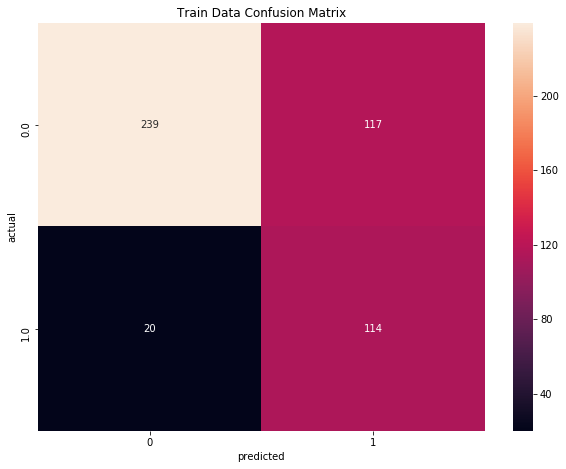

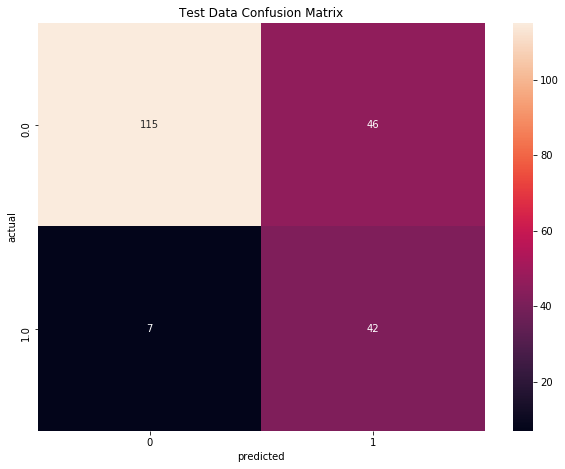

In [290]:
train_predict['predicted'] = train_predict['prob'].apply(lambda x: 1 if x > 0.24 else 0)
sns.heatmap(pd.crosstab(train_predict['actual'], train_predict['predicted']), annot=True, fmt='.0f')
plt.title('Train Data Confusion Matrix')
plt.show()

test_predict['predicted'] = test_predict['prob'].apply(lambda x: 1 if x > 0.24 else 0)
sns.heatmap(pd.crosstab(test_predict['actual'], test_predict['predicted']), annot=True, fmt='.0f')
plt.title('Test Data Confusion Matrix')
plt.show()



In [291]:
print("The overall accuracy score for the Train Data is : ", metrics.accuracy_score(train_predict.actual, train_predict.predicted))
print("The overall accuracy score for the Test Data  is : ", metrics.accuracy_score(test_predict.actual, test_predict.predicted))

The overall accuracy score for the Train Data is :  0.7204081632653061
The overall accuracy score for the Test Data  is :  0.7476190476190476


# Decile Analysis

In [292]:
train_predict['Deciles']=pd.qcut(train_predict['prob'],10, labels=False)
train_predict.head()

,actual,prob,predicted,Deciles
357,1.0,0.573708,1,8
649,0.0,0.500030,1,8
291,0.0,0.060040,0,2
420,1.0,0.574824,1,8
177,0.0,0.132731,0,3


In [293]:
df = train_predict[['Deciles','actual']].groupby(train_predict.Deciles).sum().sort_index(ascending=False)

In [294]:
df

,Deciles,actual
Deciles,,
9,441,36.0
8,392,28.0
7,343,26.0
6,294,15.0
5,245,13.0
4,196,6.0
3,147,5.0
2,98,3.0
1,49,2.0


## Hence with the decile analysis the model looks fine statistically as with the reducing probabilities we are also seeing the reducing actual default.




## Implement using logistic regression using sklearn

In [295]:
train_features = bankloans_existing.columns.difference(['default'])
train_sk_X,test_sk_X, train_sk_Y ,test_sk_Y = train_test_split(bankloans_existing[train_features],bankloans_existing['default'], test_size=0.3, random_state=42)
train_sk_X.columns

Index(['address', 'age', 'creddebt', 'debtinc', 'ed', 'employ', 'income',
       'othdebt'],
      dtype='object')

In [296]:
logisticRegr = LogisticRegression()
logisticRegr.fit(train_sk_X, train_sk_Y)


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [297]:
#Predicting the test cases
train_pred = pd.DataFrame({'actual':train_sk_Y,'predicted':logisticRegr.predict(train_sk_X)})
train_pred = train_pred.reset_index()
train_pred.drop(labels='index',axis=1,inplace=True)

In [298]:
train_gini = 2*metrics.roc_auc_score(train_sk_Y, logisticRegr.predict(train_sk_X)) - 1
print("The Gini Index for the model built on the Train Data is : ", train_gini)

test_gini = 2*metrics.roc_auc_score(test_sk_Y, result.predict(test_sk_X)) - 1
print("The Gini Index for the model built on the Test Data is : ", test_gini)

The Gini Index for the model built on the Train Data is :  0.3830706020459498
The Gini Index for the model built on the Test Data is :  0.7665103308404106


In [299]:
predict_proba_df = pd.DataFrame(logisticRegr.predict_proba(train_sk_X))
hr_test_pred = pd.concat([train_pred,predict_proba_df],axis=1)
hr_test_pred.columns=['actual','predicted','Left_0','Left_1']

In [300]:
auc_score = metrics.roc_auc_score( hr_test_pred.actual, hr_test_pred.Left_1  )
round( float( auc_score ), 2 )

0.84

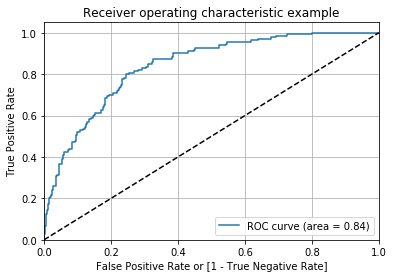

In [301]:
# Finding the optimal cutoff probability
fpr, tpr, thresholds = metrics.roc_curve( hr_test_pred.actual,hr_test_pred.Left_1,drop_intermediate=False )
plt.figure(figsize=(6, 4))
plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [302]:
cutoff_prob = thresholds[(np.abs(tpr - 0.72)).argmin()]

In [303]:
cutoff_prob

0.3663537696375335

In [304]:
hr_test_pred['new_labels'] = hr_test_pred['Left_1'].map( lambda x: 1 if x >= 0.36 else 0 )

In [305]:
print("The overall accuracy score for the Train Data is : ", round(metrics.accuracy_score(train_sk_Y, logisticRegr.predict(train_sk_X)),2))
print("The overall accuracy score for the Test Data is : ", round(metrics.accuracy_score(test_sk_Y, logisticRegr.predict(test_sk_X)),2))

The overall accuracy score for the Train Data is :  0.79
The overall accuracy score for the Test Data is :  0.85
